<a href="https://colab.research.google.com/github/grumpybavarian/tensorflow2.0/blob/master/real_nvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of a normalising flow using Real NVP.  
Inspired by these papers:  
* https://arxiv.org/abs/1605.08803
* https://papers.nips.cc/paper/8224-glow-generative-flow-with-invertible-1x1-convolutions.pdf
* https://arxiv.org/pdf/1902.02767v2.pdf  

And these materials by Eric Jang:  
* ICML Tutorial on Normalising Flows: https://slideslive.com/38917907/tutorial-on-normalizing-flows
* Normalising Flows in 100 lines of JAX: https://blog.evjang.com/2019/07/nf-jax.html

In [1]:
!pip install tensorflow-gpu==2.0

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
tf.__version__

'2.0.0'

In [0]:
def create_mlp(units, dim, n_layers):
  """
  helper function to create a simple feedforward neural network.
  Args:
    units: number of neurons to use per layer
    dim: output dimension
    n_layers: number of layers (input not included)
  """
  network = []

  for _ in range(n_layers - 1):
      network += [keras.layers.Dense(units, activation='relu')]

  network += [keras.layers.Dense(dim)]

  return keras.Sequential(network)

In [0]:
class RealNVP(keras.layers.Layer):
  """
  Implementation of a Real NVP layer with checkerboard masking.
  """
  def __init__(self, dim: int, flip: bool, units=128, layers=2):
    """
    Args:
      dim: input and output dimensionality
      flip: whether to flip the mask or not
      units: number of neurons per hidden layer in the s and t network
      layers: number of layers in the s and t network
    """
    super().__init__()
    self.dim = dim
    self.flip = flip
    self.s_net = create_mlp(units, dim, layers)
    self.t_net = create_mlp(units, dim, layers)
    
    # create checkerboard mask
    mask = np.zeros(self.dim)
    start = 0 if self.flip else 1
    mask[np.arange(start, self.dim, 2)] = 1
    self.mask = tf.convert_to_tensor(mask, dtype=tf.float32)

  def call(self, x, sldj=0, reverse=False):
    """
    Implements RNVP function. On reverse=False returns sum-log-det-jacobian (sldj).
    """
    x1 = self.mask * x
    x2 = (1. - self.mask) * x

    scale = (1 - self.mask) * self.s_net(x1)
    shift = (1 - self.mask) * self.t_net(x1)

    if reverse:
        return x1 + x2 * tf.exp(scale) + shift
    else:
        sldj += tf.reduce_sum(scale, axis=1)

        return x1 + (x2 - shift) * tf.exp(-scale), sldj

In [0]:
class NormalisingFlow(keras.layers.Layer):
  """
  Implementation of a normalising flow consisting of RNVP layers.
  """
  def __init__(self, dim: int, depth: int, units: int = 128, n_layers: int = 2):
    super().__init__()
    self.dim = dim
    self.depth = depth
    self.layers = [RealNVP(dim=dim, flip=(i%2==0), units=units, layers=n_layers)
                   for i in range(depth)]
    
  def call(self, x, reverse=False):
    if reverse:
      for l in reversed(self.layers):
        x = l(x, reverse=True)
      return x
    else:
      sldj = 0.
      for l in self.layers:
        x, sldj = l(x, sldj, reverse=False)

      return x, self.base_log_prob(x) - sldj

  def base_log_prob(self, x):
    """
    Log Probability of a sample under a standard gaussian distribution.
    """
    return tf.reduce_sum(-tf.square(x) / 2 - tf.math.log(tf.sqrt(2 * np.pi)), axis=1)
      
  def sample(self, n_samples):
    """
    generates new samples by sampling from a standard gaussian and feeding it 
    backwards through the flow.
    """
    base_samples = tf.random.normal(shape=(n_samples, self.dim))

    return self(base_samples, reverse=True)

In [0]:
# Test Real NVP layer invertibility
r = RealNVP(10, True)
x = tf.random.normal(shape=(20, 10))
z, _ = r(x, reverse=False)
x_new = r(z, reverse=True)
assert tf.norm(x - x_new) < 1e-5

In [0]:
# Test Normalising Flow invertibility
flow = NormalisingFlow(dim=10, depth=4)
x = tf.random.normal(shape=(20, 10))
z, _ = flow(x, reverse=False)
x_new = flow(z, reverse=True)
assert tf.norm(x - x_new) < 1e-5

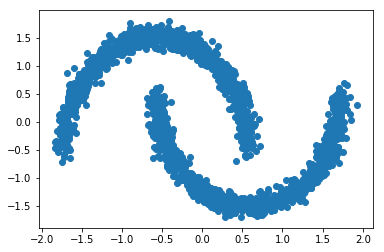

In [9]:
# create half moon dataset
batch_size = 64
X, _ = make_moons(n_samples=2000, noise=0.05)
X = StandardScaler().fit_transform(X).astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.2, )
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len(X)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)

plt.scatter(X[:, 0], X[:, 1])

In [0]:
optimiser = keras.optimizers.Adam(1e-4)
flow = NormalisingFlow(2, depth=6, units=512, n_layers=3)

In [0]:
@tf.function
def train_one_batch(batch):
  with tf.GradientTape() as tape:
    _, sldj = flow(batch)
    nlls = - sldj
    loss = - tf.reduce_mean(sldj)

    # due to the boolean masking of the output of the s and t net
    # some weights won't have gradients, `unconnected_gradients='zero'` sets
    # these to zero instead of None
    grads = tape.gradient(loss, flow.trainable_variables, unconnected_gradients='zero')

    return nlls, grads

def train_one_epoch():
  train_loss_avg = tf.keras.metrics.Mean()
  test_loss_avg = tf.keras.metrics.Mean()
  for batch in train_dataset:
    nlls, grads = train_one_batch(batch)
    optimiser.apply_gradients(zip(grads, flow.trainable_variables))
    train_loss_avg(nlls)

  for batch in test_dataset:
    _, sldj = flow(batch)
    test_loss_avg(-sldj)

  return train_loss_avg.result(), test_loss_avg.result()  

In [0]:
def plot_progress(samples):
  plt.subplot(121)
  plt.title('Dataset')
  plt.scatter(X[:, 0], X[:, 1])
  plt.subplot(122)
  plt.title('Generated Samples')
  plt.scatter(samples[:, 0], samples[:, 1])
  plt.show()

Epoch 1 / 500: Train Loss: 2.628 Test Loss: 2.544
Epoch 2 / 500: Train Loss: 2.521 Test Loss: 2.484
Epoch 3 / 500: Train Loss: 2.471 Test Loss: 2.442
Epoch 4 / 500: Train Loss: 2.423 Test Loss: 2.399
Epoch 5 / 500: Train Loss: 2.379 Test Loss: 2.382
Epoch 6 / 500: Train Loss: 2.349 Test Loss: 2.330
Epoch 7 / 500: Train Loss: 2.308 Test Loss: 2.346
Epoch 8 / 500: Train Loss: 2.309 Test Loss: 2.350
Epoch 9 / 500: Train Loss: 2.293 Test Loss: 2.261
Epoch 10 / 500: Train Loss: 2.266 Test Loss: 2.241
Epoch 11 / 500: Train Loss: 2.237 Test Loss: 2.228
Epoch 12 / 500: Train Loss: 2.201 Test Loss: 2.199
Epoch 13 / 500: Train Loss: 2.189 Test Loss: 2.183
Epoch 14 / 500: Train Loss: 2.167 Test Loss: 2.211
Epoch 15 / 500: Train Loss: 2.159 Test Loss: 2.141
Epoch 16 / 500: Train Loss: 2.119 Test Loss: 2.124
Epoch 17 / 500: Train Loss: 2.110 Test Loss: 2.271
Epoch 18 / 500: Train Loss: 2.146 Test Loss: 2.079
Epoch 19 / 500: Train Loss: 2.070 Test Loss: 2.016
Epoch 20 / 500: Train Loss: 2.078 Test L

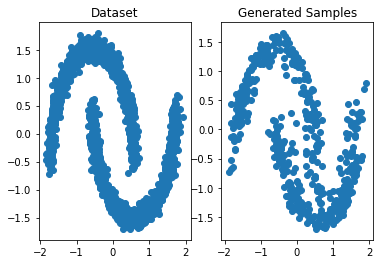

Epoch 26 / 500: Train Loss: 1.646 Test Loss: 1.690
Epoch 27 / 500: Train Loss: 1.576 Test Loss: 1.680
Epoch 28 / 500: Train Loss: 1.459 Test Loss: 1.414
Epoch 29 / 500: Train Loss: 1.412 Test Loss: 1.462
Epoch 30 / 500: Train Loss: 1.458 Test Loss: 1.538
Epoch 31 / 500: Train Loss: 1.448 Test Loss: 1.331
Epoch 32 / 500: Train Loss: 1.373 Test Loss: 1.498
Epoch 33 / 500: Train Loss: 1.479 Test Loss: 1.378
Epoch 34 / 500: Train Loss: 1.380 Test Loss: 1.406
Epoch 35 / 500: Train Loss: 1.364 Test Loss: 1.344
Epoch 36 / 500: Train Loss: 1.344 Test Loss: 1.380
Epoch 37 / 500: Train Loss: 1.386 Test Loss: 1.327
Epoch 38 / 500: Train Loss: 1.335 Test Loss: 1.328
Epoch 39 / 500: Train Loss: 1.331 Test Loss: 1.302
Epoch 40 / 500: Train Loss: 1.313 Test Loss: 1.300
Epoch 41 / 500: Train Loss: 1.294 Test Loss: 1.378
Epoch 42 / 500: Train Loss: 1.296 Test Loss: 1.305
Epoch 43 / 500: Train Loss: 1.313 Test Loss: 1.323
Epoch 44 / 500: Train Loss: 1.311 Test Loss: 1.334
Epoch 45 / 500: Train Loss: 1.3

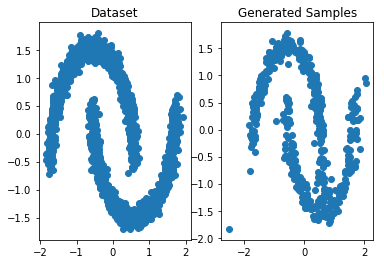

Epoch 51 / 500: Train Loss: 1.318 Test Loss: 1.375
Epoch 52 / 500: Train Loss: 1.324 Test Loss: 1.415
Epoch 53 / 500: Train Loss: 1.336 Test Loss: 1.350
Epoch 54 / 500: Train Loss: 1.297 Test Loss: 1.283
Epoch 55 / 500: Train Loss: 1.287 Test Loss: 1.343
Epoch 56 / 500: Train Loss: 1.300 Test Loss: 1.352
Epoch 57 / 500: Train Loss: 1.321 Test Loss: 1.321
Epoch 58 / 500: Train Loss: 1.304 Test Loss: 1.309
Epoch 59 / 500: Train Loss: 1.281 Test Loss: 1.282
Epoch 60 / 500: Train Loss: 1.274 Test Loss: 1.274
Epoch 61 / 500: Train Loss: 1.272 Test Loss: 1.348
Epoch 62 / 500: Train Loss: 1.346 Test Loss: 1.335
Epoch 63 / 500: Train Loss: 1.309 Test Loss: 1.330
Epoch 64 / 500: Train Loss: 1.288 Test Loss: 1.293
Epoch 65 / 500: Train Loss: 1.269 Test Loss: 1.298
Epoch 66 / 500: Train Loss: 1.330 Test Loss: 1.319
Epoch 67 / 500: Train Loss: 1.274 Test Loss: 1.266
Epoch 68 / 500: Train Loss: 1.258 Test Loss: 1.380
Epoch 69 / 500: Train Loss: 1.253 Test Loss: 1.328
Epoch 70 / 500: Train Loss: 1.2

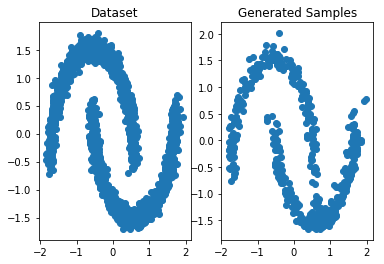

Epoch 76 / 500: Train Loss: 1.269 Test Loss: 1.276
Epoch 77 / 500: Train Loss: 1.293 Test Loss: 1.326
Epoch 78 / 500: Train Loss: 1.249 Test Loss: 1.335
Epoch 79 / 500: Train Loss: 1.304 Test Loss: 1.303
Epoch 80 / 500: Train Loss: 1.260 Test Loss: 1.292
Epoch 81 / 500: Train Loss: 1.293 Test Loss: 1.309
Epoch 82 / 500: Train Loss: 1.281 Test Loss: 1.307
Epoch 83 / 500: Train Loss: 1.297 Test Loss: 1.248
Epoch 84 / 500: Train Loss: 1.262 Test Loss: 1.350
Epoch 85 / 500: Train Loss: 1.256 Test Loss: 1.251
Epoch 86 / 500: Train Loss: 1.247 Test Loss: 1.276
Epoch 87 / 500: Train Loss: 1.267 Test Loss: 1.301
Epoch 88 / 500: Train Loss: 1.269 Test Loss: 1.275
Epoch 89 / 500: Train Loss: 1.273 Test Loss: 1.363
Epoch 90 / 500: Train Loss: 1.253 Test Loss: 1.265
Epoch 91 / 500: Train Loss: 1.248 Test Loss: 1.299
Epoch 92 / 500: Train Loss: 1.256 Test Loss: 1.337
Epoch 93 / 500: Train Loss: 1.250 Test Loss: 1.311
Epoch 94 / 500: Train Loss: 1.278 Test Loss: 1.275
Epoch 95 / 500: Train Loss: 1.2

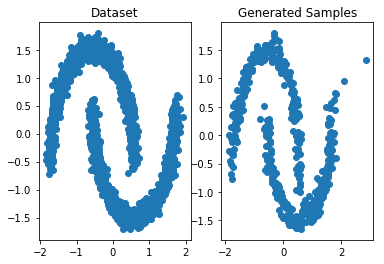

Epoch 101 / 500: Train Loss: 1.255 Test Loss: 1.271
Epoch 102 / 500: Train Loss: 1.257 Test Loss: 1.271
Epoch 103 / 500: Train Loss: 1.238 Test Loss: 1.292
Epoch 104 / 500: Train Loss: 1.286 Test Loss: 1.325
Epoch 105 / 500: Train Loss: 1.252 Test Loss: 1.343
Epoch 106 / 500: Train Loss: 1.253 Test Loss: 1.272
Epoch 107 / 500: Train Loss: 1.242 Test Loss: 1.369
Epoch 108 / 500: Train Loss: 1.284 Test Loss: 1.284
Epoch 109 / 500: Train Loss: 1.237 Test Loss: 1.325
Epoch 110 / 500: Train Loss: 1.270 Test Loss: 1.310
Epoch 111 / 500: Train Loss: 1.237 Test Loss: 1.283
Epoch 112 / 500: Train Loss: 1.227 Test Loss: 1.300
Epoch 113 / 500: Train Loss: 1.286 Test Loss: 1.268
Epoch 114 / 500: Train Loss: 1.252 Test Loss: 1.311
Epoch 115 / 500: Train Loss: 1.295 Test Loss: 1.307
Epoch 116 / 500: Train Loss: 1.246 Test Loss: 1.321
Epoch 117 / 500: Train Loss: 1.228 Test Loss: 1.280
Epoch 118 / 500: Train Loss: 1.237 Test Loss: 1.250
Epoch 119 / 500: Train Loss: 1.220 Test Loss: 1.273
Epoch 120 / 

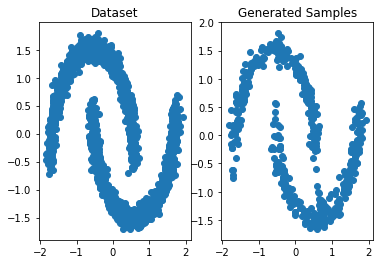

Epoch 126 / 500: Train Loss: 1.273 Test Loss: 1.274
Epoch 127 / 500: Train Loss: 1.255 Test Loss: 1.304
Epoch 128 / 500: Train Loss: 1.234 Test Loss: 1.281
Epoch 129 / 500: Train Loss: 1.230 Test Loss: 1.327
Epoch 130 / 500: Train Loss: 1.233 Test Loss: 1.382
Epoch 131 / 500: Train Loss: 1.253 Test Loss: 1.291
Epoch 132 / 500: Train Loss: 1.230 Test Loss: 1.284
Epoch 133 / 500: Train Loss: 1.240 Test Loss: 1.312
Epoch 134 / 500: Train Loss: 1.232 Test Loss: 1.362
Epoch 135 / 500: Train Loss: 1.266 Test Loss: 1.327
Epoch 136 / 500: Train Loss: 1.254 Test Loss: 1.318
Epoch 137 / 500: Train Loss: 1.246 Test Loss: 1.286
Epoch 138 / 500: Train Loss: 1.242 Test Loss: 1.282
Epoch 139 / 500: Train Loss: 1.228 Test Loss: 1.263
Epoch 140 / 500: Train Loss: 1.231 Test Loss: 1.288
Epoch 141 / 500: Train Loss: 1.235 Test Loss: 1.295
Epoch 142 / 500: Train Loss: 1.244 Test Loss: 1.224
Epoch 143 / 500: Train Loss: 1.265 Test Loss: 1.281
Epoch 144 / 500: Train Loss: 1.255 Test Loss: 1.317
Epoch 145 / 

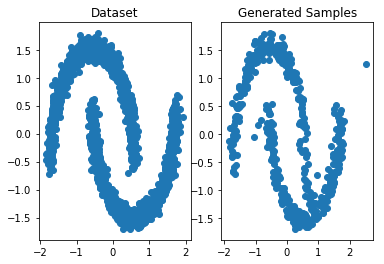

Epoch 151 / 500: Train Loss: 1.223 Test Loss: 1.290
Epoch 152 / 500: Train Loss: 1.231 Test Loss: 1.320
Epoch 153 / 500: Train Loss: 1.259 Test Loss: 1.275
Epoch 154 / 500: Train Loss: 1.284 Test Loss: 1.261
Epoch 155 / 500: Train Loss: 1.244 Test Loss: 1.273
Epoch 156 / 500: Train Loss: 1.221 Test Loss: 1.267
Epoch 157 / 500: Train Loss: 1.217 Test Loss: 1.269
Epoch 158 / 500: Train Loss: 1.208 Test Loss: 1.270
Epoch 159 / 500: Train Loss: 1.295 Test Loss: 1.270
Epoch 160 / 500: Train Loss: 1.247 Test Loss: 1.230
Epoch 161 / 500: Train Loss: 1.237 Test Loss: 1.322
Epoch 162 / 500: Train Loss: 1.247 Test Loss: 1.321
Epoch 163 / 500: Train Loss: 1.228 Test Loss: 1.307
Epoch 164 / 500: Train Loss: 1.244 Test Loss: 1.288
Epoch 165 / 500: Train Loss: 1.253 Test Loss: 1.272
Epoch 166 / 500: Train Loss: 1.233 Test Loss: 1.228
Epoch 167 / 500: Train Loss: 1.256 Test Loss: 1.250
Epoch 168 / 500: Train Loss: 1.256 Test Loss: 1.298
Epoch 169 / 500: Train Loss: 1.240 Test Loss: 1.235
Epoch 170 / 

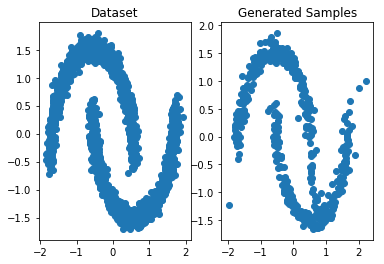

Epoch 176 / 500: Train Loss: 1.238 Test Loss: 1.253
Epoch 177 / 500: Train Loss: 1.204 Test Loss: 1.251
Epoch 178 / 500: Train Loss: 1.211 Test Loss: 1.314
Epoch 179 / 500: Train Loss: 1.218 Test Loss: 1.236
Epoch 180 / 500: Train Loss: 1.199 Test Loss: 1.328
Epoch 181 / 500: Train Loss: 1.228 Test Loss: 1.281
Epoch 182 / 500: Train Loss: 1.214 Test Loss: 1.283
Epoch 183 / 500: Train Loss: 1.220 Test Loss: 1.266
Epoch 184 / 500: Train Loss: 1.210 Test Loss: 1.323
Epoch 185 / 500: Train Loss: 1.201 Test Loss: 1.308
Epoch 186 / 500: Train Loss: 1.225 Test Loss: 1.288
Epoch 187 / 500: Train Loss: 1.225 Test Loss: 1.295
Epoch 188 / 500: Train Loss: 1.211 Test Loss: 1.319
Epoch 189 / 500: Train Loss: 1.225 Test Loss: 1.283
Epoch 190 / 500: Train Loss: 1.254 Test Loss: 1.312
Epoch 191 / 500: Train Loss: 1.235 Test Loss: 1.246
Epoch 192 / 500: Train Loss: 1.218 Test Loss: 1.270
Epoch 193 / 500: Train Loss: 1.268 Test Loss: 1.266
Epoch 194 / 500: Train Loss: 1.224 Test Loss: 1.319
Epoch 195 / 

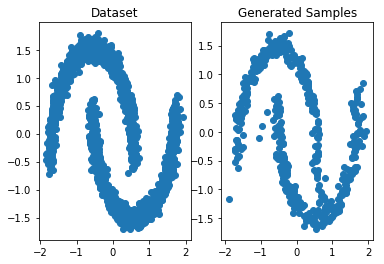

Epoch 201 / 500: Train Loss: 1.224 Test Loss: 1.273
Epoch 202 / 500: Train Loss: 1.206 Test Loss: 1.297
Epoch 203 / 500: Train Loss: 1.232 Test Loss: 1.321
Epoch 204 / 500: Train Loss: 1.212 Test Loss: 1.250
Epoch 205 / 500: Train Loss: 1.255 Test Loss: 1.271
Epoch 206 / 500: Train Loss: 1.217 Test Loss: 1.296
Epoch 207 / 500: Train Loss: 1.249 Test Loss: 1.269
Epoch 208 / 500: Train Loss: 1.218 Test Loss: 1.285
Epoch 209 / 500: Train Loss: 1.225 Test Loss: 1.295
Epoch 210 / 500: Train Loss: 1.230 Test Loss: 1.303
Epoch 211 / 500: Train Loss: 1.235 Test Loss: 1.322
Epoch 212 / 500: Train Loss: 1.206 Test Loss: 1.255
Epoch 213 / 500: Train Loss: 1.214 Test Loss: 1.324
Epoch 214 / 500: Train Loss: 1.221 Test Loss: 1.283
Epoch 215 / 500: Train Loss: 1.238 Test Loss: 1.307
Epoch 216 / 500: Train Loss: 1.207 Test Loss: 1.294
Epoch 217 / 500: Train Loss: 1.209 Test Loss: 1.246
Epoch 218 / 500: Train Loss: 1.235 Test Loss: 1.262
Epoch 219 / 500: Train Loss: 1.224 Test Loss: 1.300
Epoch 220 / 

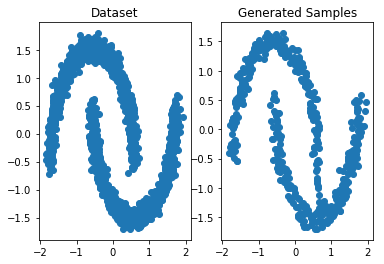

Epoch 226 / 500: Train Loss: 1.204 Test Loss: 1.294
Epoch 227 / 500: Train Loss: 1.196 Test Loss: 1.334
Epoch 228 / 500: Train Loss: 1.227 Test Loss: 1.299
Epoch 229 / 500: Train Loss: 1.207 Test Loss: 1.269
Epoch 230 / 500: Train Loss: 1.185 Test Loss: 1.299
Epoch 231 / 500: Train Loss: 1.202 Test Loss: 1.259
Epoch 232 / 500: Train Loss: 1.196 Test Loss: 1.278
Epoch 233 / 500: Train Loss: 1.252 Test Loss: 1.330
Epoch 234 / 500: Train Loss: 1.238 Test Loss: 1.243
Epoch 235 / 500: Train Loss: 1.201 Test Loss: 1.245
Epoch 236 / 500: Train Loss: 1.215 Test Loss: 1.288
Epoch 237 / 500: Train Loss: 1.212 Test Loss: 1.308
Epoch 238 / 500: Train Loss: 1.199 Test Loss: 1.277
Epoch 239 / 500: Train Loss: 1.210 Test Loss: 1.323
Epoch 240 / 500: Train Loss: 1.220 Test Loss: 1.322
Epoch 241 / 500: Train Loss: 1.223 Test Loss: 1.274
Epoch 242 / 500: Train Loss: 1.185 Test Loss: 1.277
Epoch 243 / 500: Train Loss: 1.189 Test Loss: 1.292
Epoch 244 / 500: Train Loss: 1.206 Test Loss: 1.301
Epoch 245 / 

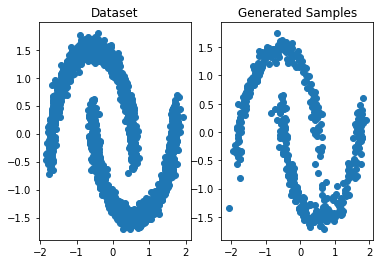

Epoch 251 / 500: Train Loss: 1.230 Test Loss: 1.264
Epoch 252 / 500: Train Loss: 1.199 Test Loss: 1.281
Epoch 253 / 500: Train Loss: 1.204 Test Loss: 1.309
Epoch 254 / 500: Train Loss: 1.212 Test Loss: 1.292
Epoch 255 / 500: Train Loss: 1.224 Test Loss: 1.282
Epoch 256 / 500: Train Loss: 1.200 Test Loss: 1.290
Epoch 257 / 500: Train Loss: 1.209 Test Loss: 1.308
Epoch 258 / 500: Train Loss: 1.189 Test Loss: 1.276
Epoch 259 / 500: Train Loss: 1.196 Test Loss: 1.261
Epoch 260 / 500: Train Loss: 1.208 Test Loss: 1.296
Epoch 261 / 500: Train Loss: 1.203 Test Loss: 1.272
Epoch 262 / 500: Train Loss: 1.199 Test Loss: 1.276
Epoch 263 / 500: Train Loss: 1.201 Test Loss: 1.279
Epoch 264 / 500: Train Loss: 1.203 Test Loss: 1.282
Epoch 265 / 500: Train Loss: 1.213 Test Loss: 1.280
Epoch 266 / 500: Train Loss: 1.189 Test Loss: 1.269
Epoch 267 / 500: Train Loss: 1.204 Test Loss: 1.312
Epoch 268 / 500: Train Loss: 1.212 Test Loss: 1.259
Epoch 269 / 500: Train Loss: 1.204 Test Loss: 1.316
Epoch 270 / 

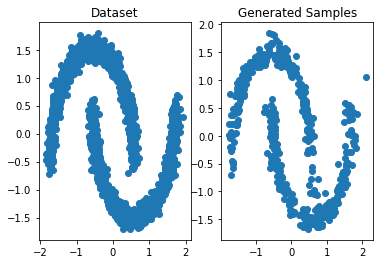

Epoch 276 / 500: Train Loss: 1.208 Test Loss: 1.258
Epoch 277 / 500: Train Loss: 1.216 Test Loss: 1.265
Epoch 278 / 500: Train Loss: 1.201 Test Loss: 1.271
Epoch 279 / 500: Train Loss: 1.230 Test Loss: 1.254
Epoch 280 / 500: Train Loss: 1.209 Test Loss: 1.256
Epoch 281 / 500: Train Loss: 1.204 Test Loss: 1.373
Epoch 282 / 500: Train Loss: 1.218 Test Loss: 1.279
Epoch 283 / 500: Train Loss: 1.194 Test Loss: 1.299
Epoch 284 / 500: Train Loss: 1.191 Test Loss: 1.242
Epoch 285 / 500: Train Loss: 1.176 Test Loss: 1.281
Epoch 286 / 500: Train Loss: 1.193 Test Loss: 1.282
Epoch 287 / 500: Train Loss: 1.199 Test Loss: 1.255
Epoch 288 / 500: Train Loss: 1.204 Test Loss: 1.282
Epoch 289 / 500: Train Loss: 1.201 Test Loss: 1.335
Epoch 290 / 500: Train Loss: 1.200 Test Loss: 1.235
Epoch 291 / 500: Train Loss: 1.190 Test Loss: 1.323
Epoch 292 / 500: Train Loss: 1.214 Test Loss: 1.325
Epoch 293 / 500: Train Loss: 1.206 Test Loss: 1.302
Epoch 294 / 500: Train Loss: 1.224 Test Loss: 1.324
Epoch 295 / 

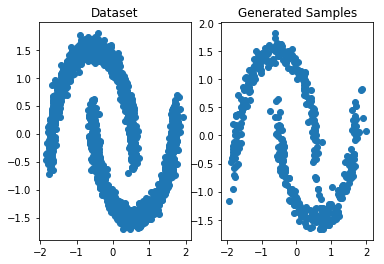

Epoch 301 / 500: Train Loss: 1.210 Test Loss: 1.262
Epoch 302 / 500: Train Loss: 1.212 Test Loss: 1.267
Epoch 303 / 500: Train Loss: 1.189 Test Loss: 1.286
Epoch 304 / 500: Train Loss: 1.215 Test Loss: 1.299
Epoch 305 / 500: Train Loss: 1.206 Test Loss: 1.286
Epoch 306 / 500: Train Loss: 1.190 Test Loss: 1.269
Epoch 307 / 500: Train Loss: 1.206 Test Loss: 1.335
Epoch 308 / 500: Train Loss: 1.191 Test Loss: 1.277
Epoch 309 / 500: Train Loss: 1.182 Test Loss: 1.264
Epoch 310 / 500: Train Loss: 1.186 Test Loss: 1.399
Epoch 311 / 500: Train Loss: 1.243 Test Loss: 1.311
Epoch 312 / 500: Train Loss: 1.201 Test Loss: 1.278
Epoch 313 / 500: Train Loss: 1.199 Test Loss: 1.259
Epoch 314 / 500: Train Loss: 1.190 Test Loss: 1.309
Epoch 315 / 500: Train Loss: 1.189 Test Loss: 1.255
Epoch 316 / 500: Train Loss: 1.181 Test Loss: 1.268
Epoch 317 / 500: Train Loss: 1.177 Test Loss: 1.302
Epoch 318 / 500: Train Loss: 1.197 Test Loss: 1.241
Epoch 319 / 500: Train Loss: 1.203 Test Loss: 1.283
Epoch 320 / 

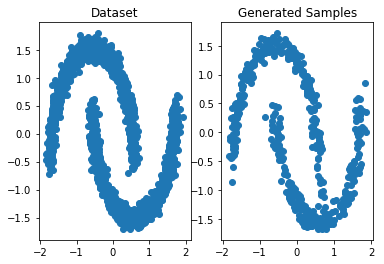

Epoch 326 / 500: Train Loss: 1.203 Test Loss: 1.268
Epoch 327 / 500: Train Loss: 1.184 Test Loss: 1.276
Epoch 328 / 500: Train Loss: 1.230 Test Loss: 1.289
Epoch 329 / 500: Train Loss: 1.201 Test Loss: 1.261
Epoch 330 / 500: Train Loss: 1.182 Test Loss: 1.258
Epoch 331 / 500: Train Loss: 1.188 Test Loss: 1.251
Epoch 332 / 500: Train Loss: 1.192 Test Loss: 1.314
Epoch 333 / 500: Train Loss: 1.184 Test Loss: 1.248
Epoch 334 / 500: Train Loss: 1.171 Test Loss: 1.269
Epoch 335 / 500: Train Loss: 1.196 Test Loss: 1.287
Epoch 336 / 500: Train Loss: 1.194 Test Loss: 1.320
Epoch 337 / 500: Train Loss: 1.208 Test Loss: 1.306
Epoch 338 / 500: Train Loss: 1.216 Test Loss: 1.273
Epoch 339 / 500: Train Loss: 1.180 Test Loss: 1.262
Epoch 340 / 500: Train Loss: 1.194 Test Loss: 1.293
Epoch 341 / 500: Train Loss: 1.193 Test Loss: 1.278
Epoch 342 / 500: Train Loss: 1.184 Test Loss: 1.295
Epoch 343 / 500: Train Loss: 1.172 Test Loss: 1.264
Epoch 344 / 500: Train Loss: 1.166 Test Loss: 1.261
Epoch 345 / 

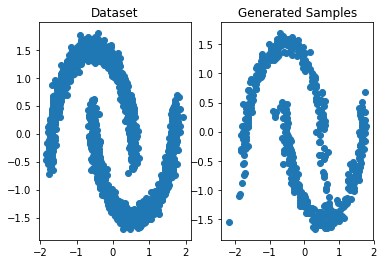

Epoch 351 / 500: Train Loss: 1.173 Test Loss: 1.291
Epoch 352 / 500: Train Loss: 1.249 Test Loss: 1.289
Epoch 353 / 500: Train Loss: 1.188 Test Loss: 1.264
Epoch 354 / 500: Train Loss: 1.171 Test Loss: 1.269
Epoch 355 / 500: Train Loss: 1.158 Test Loss: 1.302
Epoch 356 / 500: Train Loss: 1.199 Test Loss: 1.264
Epoch 357 / 500: Train Loss: 1.182 Test Loss: 1.260
Epoch 358 / 500: Train Loss: 1.170 Test Loss: 1.242
Epoch 359 / 500: Train Loss: 1.194 Test Loss: 1.324
Epoch 360 / 500: Train Loss: 1.199 Test Loss: 1.253
Epoch 361 / 500: Train Loss: 1.175 Test Loss: 1.251
Epoch 362 / 500: Train Loss: 1.198 Test Loss: 1.289
Epoch 363 / 500: Train Loss: 1.186 Test Loss: 1.303
Epoch 364 / 500: Train Loss: 1.193 Test Loss: 1.309
Epoch 365 / 500: Train Loss: 1.232 Test Loss: 1.257
Epoch 366 / 500: Train Loss: 1.195 Test Loss: 1.318
Epoch 367 / 500: Train Loss: 1.176 Test Loss: 1.239
Epoch 368 / 500: Train Loss: 1.210 Test Loss: 1.321
Epoch 369 / 500: Train Loss: 1.199 Test Loss: 1.274
Epoch 370 / 

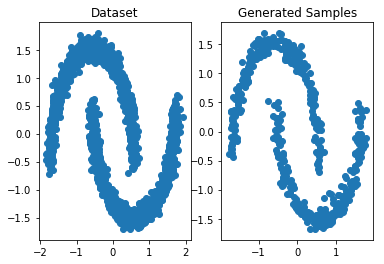

Epoch 376 / 500: Train Loss: 1.183 Test Loss: 1.271
Epoch 377 / 500: Train Loss: 1.237 Test Loss: 1.312
Epoch 378 / 500: Train Loss: 1.197 Test Loss: 1.259
Epoch 379 / 500: Train Loss: 1.184 Test Loss: 1.275
Epoch 380 / 500: Train Loss: 1.164 Test Loss: 1.248
Epoch 381 / 500: Train Loss: 1.178 Test Loss: 1.263
Epoch 382 / 500: Train Loss: 1.172 Test Loss: 1.289
Epoch 383 / 500: Train Loss: 1.187 Test Loss: 1.292
Epoch 384 / 500: Train Loss: 1.163 Test Loss: 1.276
Epoch 385 / 500: Train Loss: 1.198 Test Loss: 1.314
Epoch 386 / 500: Train Loss: 1.200 Test Loss: 1.343
Epoch 387 / 500: Train Loss: 1.187 Test Loss: 1.290
Epoch 388 / 500: Train Loss: 1.197 Test Loss: 1.269
Epoch 389 / 500: Train Loss: 1.177 Test Loss: 1.269
Epoch 390 / 500: Train Loss: 1.206 Test Loss: 1.284
Epoch 391 / 500: Train Loss: 1.222 Test Loss: 1.347
Epoch 392 / 500: Train Loss: 1.194 Test Loss: 1.281
Epoch 393 / 500: Train Loss: 1.169 Test Loss: 1.263
Epoch 394 / 500: Train Loss: 1.158 Test Loss: 1.255
Epoch 395 / 

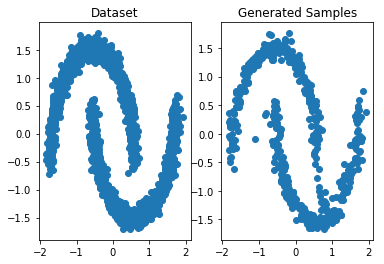

Epoch 401 / 500: Train Loss: 1.179 Test Loss: 1.292
Epoch 402 / 500: Train Loss: 1.171 Test Loss: 1.245
Epoch 403 / 500: Train Loss: 1.163 Test Loss: 1.336
Epoch 404 / 500: Train Loss: 1.229 Test Loss: 1.287
Epoch 405 / 500: Train Loss: 1.174 Test Loss: 1.292
Epoch 406 / 500: Train Loss: 1.174 Test Loss: 1.259
Epoch 407 / 500: Train Loss: 1.183 Test Loss: 1.305
Epoch 408 / 500: Train Loss: 1.184 Test Loss: 1.299
Epoch 409 / 500: Train Loss: 1.200 Test Loss: 1.253
Epoch 410 / 500: Train Loss: 1.169 Test Loss: 1.293
Epoch 411 / 500: Train Loss: 1.149 Test Loss: 1.335
Epoch 412 / 500: Train Loss: 1.164 Test Loss: 1.277
Epoch 413 / 500: Train Loss: 1.162 Test Loss: 1.279
Epoch 414 / 500: Train Loss: 1.188 Test Loss: 1.259
Epoch 415 / 500: Train Loss: 1.160 Test Loss: 1.246
Epoch 416 / 500: Train Loss: 1.172 Test Loss: 1.286
Epoch 417 / 500: Train Loss: 1.186 Test Loss: 1.280
Epoch 418 / 500: Train Loss: 1.179 Test Loss: 1.347
Epoch 419 / 500: Train Loss: 1.194 Test Loss: 1.260
Epoch 420 / 

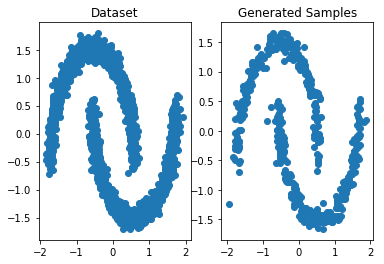

Epoch 426 / 500: Train Loss: 1.212 Test Loss: 1.323
Epoch 427 / 500: Train Loss: 1.177 Test Loss: 1.273
Epoch 428 / 500: Train Loss: 1.198 Test Loss: 1.251
Epoch 429 / 500: Train Loss: 1.200 Test Loss: 1.271
Epoch 430 / 500: Train Loss: 1.211 Test Loss: 1.270
Epoch 431 / 500: Train Loss: 1.167 Test Loss: 1.275
Epoch 432 / 500: Train Loss: 1.184 Test Loss: 1.298
Epoch 433 / 500: Train Loss: 1.178 Test Loss: 1.290
Epoch 434 / 500: Train Loss: 1.228 Test Loss: 1.257
Epoch 435 / 500: Train Loss: 1.204 Test Loss: 1.277
Epoch 436 / 500: Train Loss: 1.180 Test Loss: 1.282
Epoch 437 / 500: Train Loss: 1.191 Test Loss: 1.254
Epoch 438 / 500: Train Loss: 1.189 Test Loss: 1.277
Epoch 439 / 500: Train Loss: 1.156 Test Loss: 1.258
Epoch 440 / 500: Train Loss: 1.193 Test Loss: 1.243
Epoch 441 / 500: Train Loss: 1.179 Test Loss: 1.292
Epoch 442 / 500: Train Loss: 1.170 Test Loss: 1.257
Epoch 443 / 500: Train Loss: 1.197 Test Loss: 1.293
Epoch 444 / 500: Train Loss: 1.194 Test Loss: 1.251
Epoch 445 / 

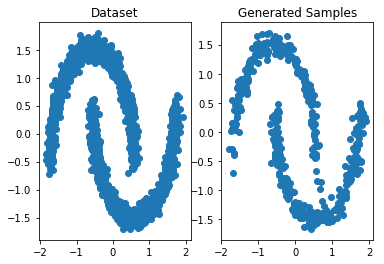

Epoch 451 / 500: Train Loss: 1.165 Test Loss: 1.292
Epoch 452 / 500: Train Loss: 1.160 Test Loss: 1.343
Epoch 453 / 500: Train Loss: 1.246 Test Loss: 1.272
Epoch 454 / 500: Train Loss: 1.202 Test Loss: 1.277
Epoch 455 / 500: Train Loss: 1.185 Test Loss: 1.243
Epoch 456 / 500: Train Loss: 1.169 Test Loss: 1.299
Epoch 457 / 500: Train Loss: 1.187 Test Loss: 1.254
Epoch 458 / 500: Train Loss: 1.171 Test Loss: 1.240
Epoch 459 / 500: Train Loss: 1.158 Test Loss: 1.283
Epoch 460 / 500: Train Loss: 1.176 Test Loss: 1.263
Epoch 461 / 500: Train Loss: 1.167 Test Loss: 1.307
Epoch 462 / 500: Train Loss: 1.174 Test Loss: 1.272
Epoch 463 / 500: Train Loss: 1.155 Test Loss: 1.252
Epoch 464 / 500: Train Loss: 1.158 Test Loss: 1.259
Epoch 465 / 500: Train Loss: 1.164 Test Loss: 1.301
Epoch 466 / 500: Train Loss: 1.180 Test Loss: 1.315
Epoch 467 / 500: Train Loss: 1.203 Test Loss: 1.236
Epoch 468 / 500: Train Loss: 1.166 Test Loss: 1.355
Epoch 469 / 500: Train Loss: 1.196 Test Loss: 1.252
Epoch 470 / 

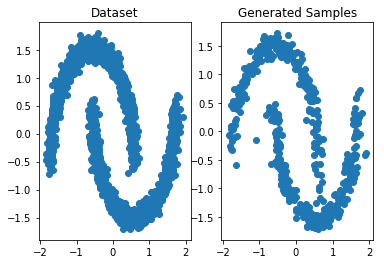

Epoch 476 / 500: Train Loss: 1.180 Test Loss: 1.300
Epoch 477 / 500: Train Loss: 1.226 Test Loss: 1.275
Epoch 478 / 500: Train Loss: 1.159 Test Loss: 1.251
Epoch 479 / 500: Train Loss: 1.190 Test Loss: 1.266
Epoch 480 / 500: Train Loss: 1.173 Test Loss: 1.288
Epoch 481 / 500: Train Loss: 1.185 Test Loss: 1.277
Epoch 482 / 500: Train Loss: 1.178 Test Loss: 1.302
Epoch 483 / 500: Train Loss: 1.153 Test Loss: 1.281
Epoch 484 / 500: Train Loss: 1.175 Test Loss: 1.311
Epoch 485 / 500: Train Loss: 1.188 Test Loss: 1.301
Epoch 486 / 500: Train Loss: 1.211 Test Loss: 1.304
Epoch 487 / 500: Train Loss: 1.181 Test Loss: 1.299
Epoch 488 / 500: Train Loss: 1.177 Test Loss: 1.269
Epoch 489 / 500: Train Loss: 1.192 Test Loss: 1.289
Epoch 490 / 500: Train Loss: 1.157 Test Loss: 1.266
Epoch 491 / 500: Train Loss: 1.170 Test Loss: 1.267
Epoch 492 / 500: Train Loss: 1.147 Test Loss: 1.254
Epoch 493 / 500: Train Loss: 1.168 Test Loss: 1.308
Epoch 494 / 500: Train Loss: 1.191 Test Loss: 1.285
Epoch 495 / 

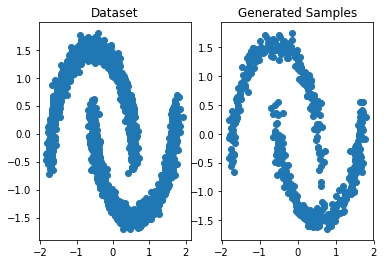

In [13]:
n_epochs = 500

for epoch in range(1, n_epochs + 1):
  train_loss, test_loss = train_one_epoch()
  print(f'Epoch {epoch} / {n_epochs}: Train Loss: {train_loss.numpy():.3f} Test Loss: {test_loss.numpy():.3f}')
  if epoch % 25 == 0:
    samples = flow.sample(500)
    plot_progress(samples)

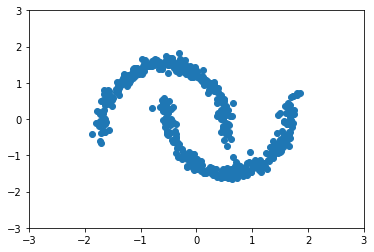

In [14]:
"""
create animation how a normalising flow transforms a standard gaussian layer by layer into
the target distribution and back into a standard gaussian.
"""

from matplotlib import animation, rc
rc('animation', html='html5')

samples = flow.sample(500)
anim_data = [samples]
for l in flow.layers:
  samples, _ = l(samples, reverse=False)
  anim_data.append(samples)

for l in reversed(flow.layers):
  samples = l(samples, reverse=True)
  anim_data.append(samples)

fig = plt.figure()
scat = plt.scatter(anim_data[0][:, 0], anim_data[0][:, 1])
plt.xlim(-3, 3)
plt.ylim(-3, 3)

def update_plot(i, data, scat):
    scat.set_offsets(data[i])
    return scat,

anim = animation.FuncAnimation(fig, update_plot, interval=500, frames=len(anim_data), fargs=(anim_data, scat))

In [15]:
anim